In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle


Expectation of OU Process: 0.24171401689703645
Variance of OU Process: 0.02522297483522722


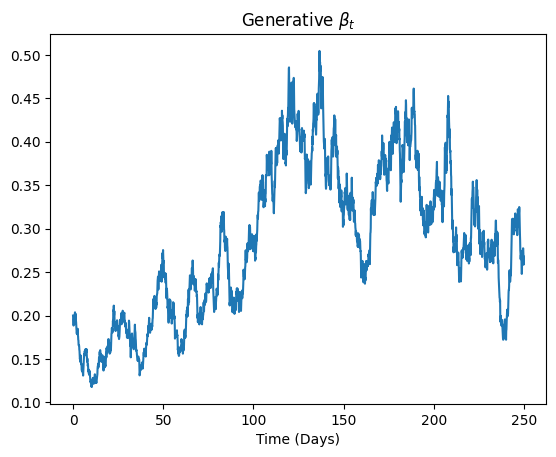

In [44]:
'''Simulated Data, setting up the SIR model'''

rng = np.random.default_rng(5)
model_params = {'gamma':1/100,'L':0,'D':1/7,'hosp':1/14,'R':100}

T = 250
dt = 0.1

SIRS_OU_model_params = jsonpickle.encode(model_params)

with open("../param_sets/SIRH_OU_model_params.json", "w+") as f:
    f.write(SIRS_OU_model_params)

t_vec = np.arange(0,T,dt)

'''IC'''
N = 100_000
I = 100

'''OU params'''
OU_params = {'lambda':1/50,'mean_ou':-1.5,'sig':0.4}

SIRS_OU_process_params = jsonpickle.encode(OU_params)
with open("../param_sets/SIRH_OU_process_params.json", "w+") as f:
    f.write(SIRS_OU_process_params)

gamma,L,D,hosp,R = model_params.values()
lam,mean_ou,sig = OU_params.values()

print(f"Expectation of OU Process: {np.exp(mean_ou + (sig**2)/2)}")
print(f"Variance of OU Process: {np.exp(sig**2 - 1) * np.exp(2 * mean_ou + sig**2)}")


A = np.exp(-lam * dt)
M = mean_ou * (np.exp(-lam * dt) - 1)
C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

betas = np.zeros_like(t_vec)
betas[0] = 0.2
for time_index in range(1,len(t_vec)):
    betas[time_index] = np.exp(A * np.log(betas[time_index - 1]) - M + C * rng.normal(0,1))

state = np.zeros((4,len(t_vec)))
state[:,0] = np.array([N - I,I,0,0])

plt.title('Generative $\\beta_t$')
plt.xlabel('Time (Days)')
plt.plot(t_vec,betas)

for time_index in range(1,len(t_vec)):
   new_S = rng.poisson((L * state[3,time_index-1]) * dt)
   new_I = rng.poisson((betas[time_index - 1] * (state[0,time_index-1] * state[1,time_index-1])/np.sum(state[:,time_index-1])) * dt)
   new_IH = rng.poisson((D * gamma * state[1,time_index-1]) * dt)
   new_HR = rng.poisson((hosp * state[2,time_index-1]) * dt)
   new_IR = rng.poisson((D *(1 - gamma) * state[1,time_index-1]) * dt)

   state[0,time_index] = np.maximum(0.,state[0,time_index-1] + new_S - new_I)
   state[1,time_index] = np.maximum(0.,state[1,time_index-1] + new_I - (new_IH + new_IR))
   state[2,time_index] = np.maximum(0.,state[2,time_index-1] + new_IH - new_HR)
   state[3,time_index] = np.maximum(0.,state[3,time_index-1] + new_HR + new_IR - new_S)

    

In [45]:
pd.DataFrame(state).to_csv('../data_sets/ou_SIRH_state_nbinom.csv',index = False)
pd.DataFrame(betas).to_csv('../data_sets/ou_SIRH_betas_nbinom.csv',index = False)

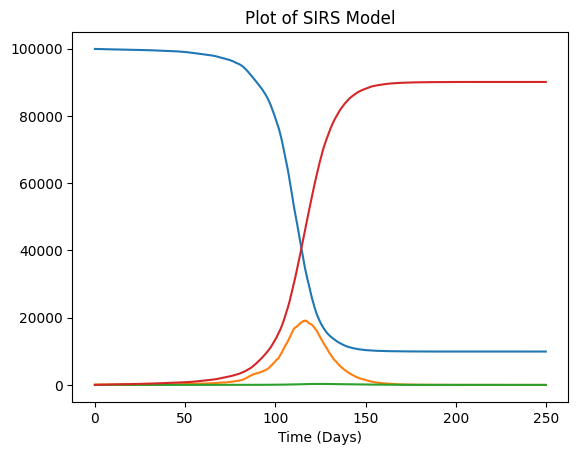

In [46]:

plt.title('Plot of SIRS Model')
plt.xlabel('Time (Days)')
plt.plot(t_vec,state.T)

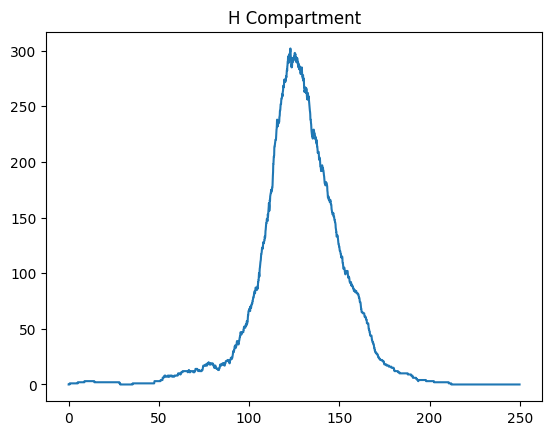

In [47]:
plt.title('H Compartment')
plt.plot(t_vec,state[2,:].T)

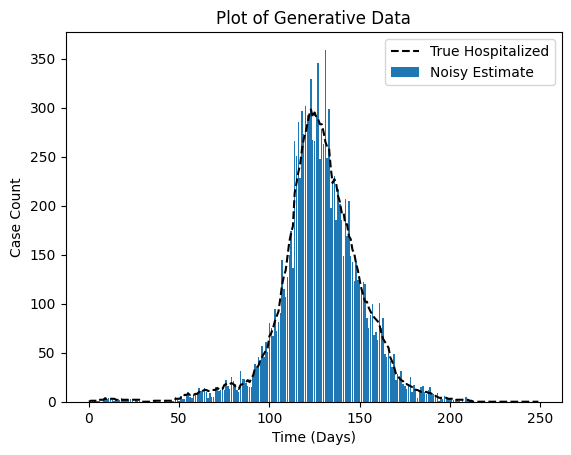

In [48]:
data = np.expand_dims(rng.negative_binomial(n = R,p = R/(R + state[2,::int(1/dt)] + 0.005)),0)

plt.title('Plot of Generative Data')
plt.xlabel('Time (Days)')
plt.ylabel('Case Count')
plt.plot(t_vec[::int(1/dt)],state[2,::int(1/dt)],'--',color = 'black',label = 'True Hospitalized')
plt.bar(t_vec[::int(1/dt)],data[0,:],label = 'Noisy Estimate')
plt.legend()

In [49]:
pd.DataFrame(data).to_csv('../data_sets/ou_SIRH_data_nbinom.csv',index = False)